In [1]:
import pandas as pd
from sqlalchemy import create_engine
import pyodbc


In [4]:
# Connect to dataBase 
server = "."
database = "BikeStores"

connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

engine = create_engine(connection_string)

In [5]:
# --- Step 2: Write the CORRECTED SQL query with schemas ---
query = """
SELECT
    o.order_id,
    o.order_date,
    c.first_name,
    c.last_name,
    c.city,
    c.state,
    st.store_name,
    p.product_name,
    cat.category_name,
    b.brand_name,
    oi.quantity,
    oi.list_price,
    oi.discount
FROM sales.orders o
JOIN sales.customers c ON o.customer_id = c.customer_id
JOIN sales.stores st ON o.store_id = st.store_id
JOIN sales.order_items oi ON o.order_id = oi.order_id
JOIN production.products p ON oi.product_id = p.product_id
JOIN production.categories cat ON p.category_id = cat.category_id
JOIN production.brands b ON p.brand_id = b.brand_id;
"""

# --- Step 3: Load the data into a DataFrame ---
df = pd.read_sql_query(query, engine)

# Let's see the first 5 rows!
print(df.head())

   order_id  order_date first_name  last_name        city state  \
0         1  2016-01-01  Johnathan  Velazquez  Pleasanton    CA   
1         1  2016-01-01  Johnathan  Velazquez  Pleasanton    CA   
2         1  2016-01-01  Johnathan  Velazquez  Pleasanton    CA   
3         1  2016-01-01  Johnathan  Velazquez  Pleasanton    CA   
4         1  2016-01-01  Johnathan  Velazquez  Pleasanton    CA   

         store_name                                    product_name  \
0  Santa Cruz Bikes  Electra Townie Original 7D EQ - Women's - 2016   
1  Santa Cruz Bikes           Trek Remedy 29 Carbon Frameset - 2016   
2  Santa Cruz Bikes                          Surly Straggler - 2016   
3  Santa Cruz Bikes            Electra Townie Original 7D EQ - 2016   
4  Santa Cruz Bikes                        Trek Fuel EX 8 29 - 2016   

         category_name brand_name  quantity  list_price  discount  
0    Cruisers Bicycles    Electra         1      599.99      0.20  
1       Mountain Bikes       Trek 

## 2. Exploratory Data Analysis (EDA) 

Now that our data is loaded, we need to get to know it. EDA is like being a detective: you're looking for clues about the data's structure, quality, and patterns.

df.info() - The Technical Summary

This is your first and most important command. It gives you a summary of the DataFrame, including:

The number of entries (rows).

The number of columns.

The name and data type (Dtype) of each column.

The number of non-null (i.e., not empty) values. This is crucial for spotting missing data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4722 entries, 0 to 4721
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       4722 non-null   int64  
 1   order_date     4722 non-null   object 
 2   first_name     4722 non-null   object 
 3   last_name      4722 non-null   object 
 4   city           4722 non-null   object 
 5   state          4722 non-null   object 
 6   store_name     4722 non-null   object 
 7   product_name   4722 non-null   object 
 8   category_name  4722 non-null   object 
 9   brand_name     4722 non-null   object 
 10  quantity       4722 non-null   int64  
 11  list_price     4722 non-null   float64
 12  discount       4722 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 479.7+ KB


In [ ]:
#You'll notice the order_date is an object (text) type. We'll need to fix that!

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,4722.0,821.265354,465.152168,1.00,423.25,828.500,1226.0,1615.00
quantity,4722.0,1.498941,0.500052,1.00,1.00,1.000,2.0,2.00
list_price,4722.0,1212.707872,1352.798257,89.99,429.00,599.990,1549.0,11999.99
discount,4722.0,0.105373,0.058119,0.05,0.05,0.085,0.2,0.20


In [ ]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
print("Columns:", df.columns.tolist())

## 3. Data Cleaning

In [9]:
#Handling Data Types

# Convert 'order_date' from object to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Verify the change
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4722 entries, 0 to 4721
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       4722 non-null   int64         
 1   order_date     4722 non-null   datetime64[ns]
 2   first_name     4722 non-null   object        
 3   last_name      4722 non-null   object        
 4   city           4722 non-null   object        
 5   state          4722 non-null   object        
 6   store_name     4722 non-null   object        
 7   product_name   4722 non-null   object        
 8   category_name  4722 non-null   object        
 9   brand_name     4722 non-null   object        
 10  quantity       4722 non-null   int64         
 11  list_price     4722 non-null   float64       
 12  discount       4722 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 479.7+ KB
None


In [10]:
# Sum up all null values for each column
print(df.isnull().sum())

order_id         0
order_date       0
first_name       0
last_name        0
city             0
state            0
store_name       0
product_name     0
category_name    0
brand_name       0
quantity         0
list_price       0
discount         0
dtype: int64


In [11]:
# Create a 'revenue' column
df['revenue'] = df['quantity'] * df['list_price'] * (1 - df['discount'])

print(df[['quantity', 'list_price', 'discount', 'revenue']].head())

   quantity  list_price  discount    revenue
0         1      599.99      0.20   479.9920
1         2     1799.99      0.07  3347.9814
2         2     1549.00      0.05  2943.1000
3         2      599.99      0.05  1139.9810
4         1     2899.99      0.20  2319.9920


# 4. Answering Business Questions with Aggregation 

Now for the exciting part! We can ask business questions and use pandas to find the answers. This is where aggregation methods like groupby() come in. groupby() works by splitting the data into groups, applying a function to each group (like sum(), mean(), count()), and then combining the results.


In [12]:
# Top 10 best-selling products by revenue
top_products = df.groupby('product_name')['revenue'].sum().sort_values(ascending=False)
print("--- Top 10 Products ---")
print(top_products.head(10))

print("\n" + "="*30 + "\n")

# Top selling categories by revenue
top_categories = df.groupby('category_name')['revenue'].sum().sort_values(ascending=False)
print("--- Top Categories ---")
print(top_categories)

--- Top 10 Products ---
product_name
Trek Slash 8 27.5 - 2016                 555558.6111
Trek Conduit+ - 2016                     389248.7025
Trek Fuel EX 8 29 - 2016                 368472.7294
Surly Straggler 650b - 2016              226765.5510
Trek Domane SLR 6 Disc - 2017            211584.6153
Surly Straggler - 2016                   203507.6200
Trek Remedy 29 Carbon Frameset - 2016    203380.8701
Trek Powerfly 8 FS Plus - 2017           188249.6235
Trek Madone 9.2 - 2017                   175899.6482
Trek Silque SLR 8 Women's - 2017         174524.7315
Name: revenue, dtype: float64


--- Top Categories ---
category_name
Mountain Bikes         2.715080e+06
Road Bikes             1.665098e+06
Cruisers Bicycles      9.950326e+05
Electric Bikes         9.166848e+05
Cyclocross Bicycles    7.110118e+05
Comfort Bicycles       3.940201e+05
Children Bicycles      2.921892e+05
Name: revenue, dtype: float64


In [ ]:
#Business Question 2: Who are our Top 5 Customers by total spending?


In [13]:
# Create a 'full_name' column
df['full_name'] = df['first_name'] + ' ' + df['last_name']

# Find top 5 customers by revenue
top_customers = df.groupby('full_name')['revenue'].sum().sort_values(ascending=False)
print("--- Top 5 Customers ---")
print(top_customers.head(5))

--- Top 5 Customers ---
full_name
Sharyn Hopkins    34807.9392
Pamelia Newman    33634.2604
Abby Gamble       32803.0062
Lyndsey Bean      32675.0725
Emmitt Sanchez    31925.8857
Name: revenue, dtype: float64


In [14]:
# Extract the month period (e.g., '2016-01')
df['order_month'] = df['order_date'].dt.to_period('M')

# Group by month and sum the revenue
monthly_revenue = df.groupby('order_month')['revenue'].sum()

print("--- Monthly Revenue ---")
print(monthly_revenue.head())


--- Monthly Revenue ---
order_month
2016-01    215146.4241
2016-02    156112.3228
2016-03    180600.3285
2016-04    167144.0512
2016-05    205270.0091
Freq: M, Name: revenue, dtype: float64


## 5. Data Visualization 

A picture is worth a thousand words (or a thousand rows of data!). Let's visualize the answers to our business questions using Matplotlib and Seaborn.

C:\Users\Mohamed Nofal\AppData\Local\Temp\ipykernel_59736\4268892846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')


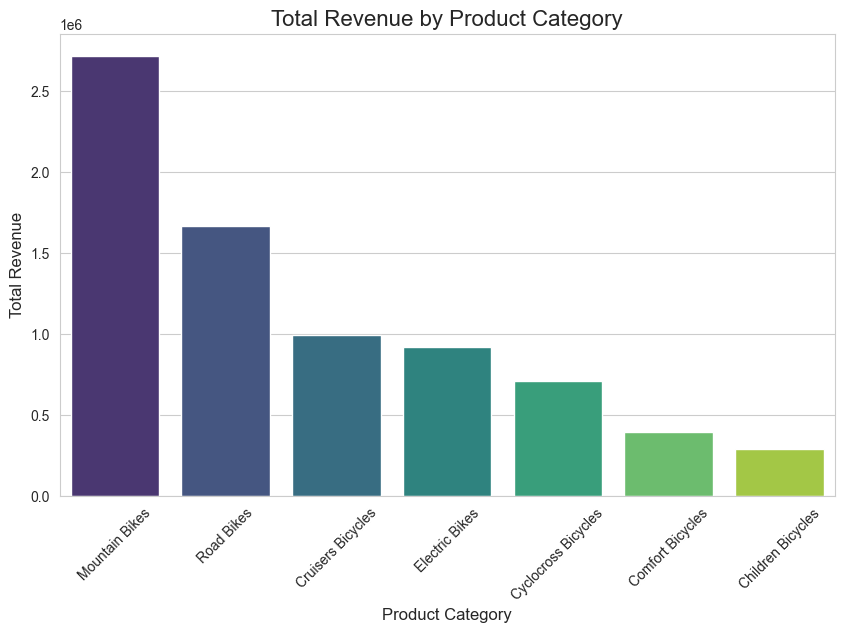

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6)) # Create a figure to draw on
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
plt.title('Total Revenue by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45) # Rotate category names for better readability
plt.show()

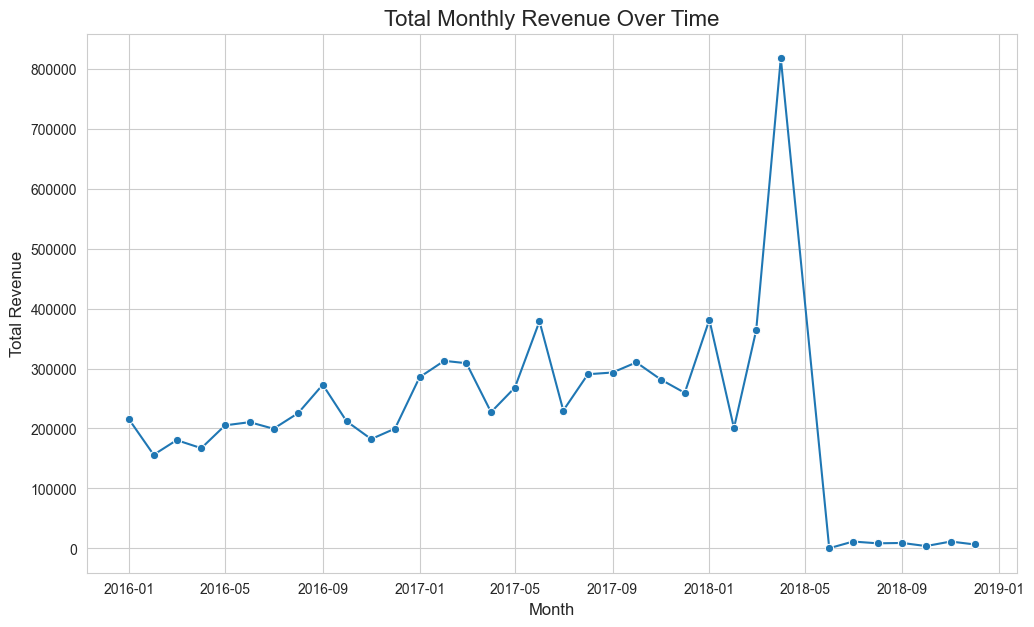

In [16]:
#Line Chart: Monthly Revenue Over Time

# The index of monthly_revenue is the month period, so we need to convert it to a timestamp for plotting
monthly_revenue_df = monthly_revenue.to_frame().reset_index()
monthly_revenue_df['order_month'] = monthly_revenue_df['order_month'].dt.to_timestamp()


plt.figure(figsize=(12, 7))
sns.lineplot(x='order_month', y='revenue', data=monthly_revenue_df, marker='o')
plt.title('Total Monthly Revenue Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.show()
